In [47]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

parent_dir = str(Path().resolve().parents[0])
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [48]:
np.random.seed(5)

num_a = 100
num_b = 75
num_blocked_pairs = 2 * (num_a + num_b)

num_iters = int(1e3)

# locs
a = np.arange(num_a)# * (num_b / num_a)
b = np.arange(num_b)

# weights 
mu = np.random.normal(loc=5.0, scale=1.0, size=a.shape[0])
mu_0 = mu.copy()

nu = np.random.normal(loc=7.0, scale=1.5, size=b.shape[0])
nu_0 = nu.copy()

In [49]:
gamma_0 = 10.0 # regularisation
gamma_c = 15.0 # column constraints
gamma_r = 15.0 # row constraints

# select which constraints to enforce
rows_to_relax = np.random.choice([0,1], size=(num_a,1), p=[0.75,0.25])
cols_to_relax = np.random.choice([0,1], size=(1,num_b), p=[0.5,0.5])

# plan constraints
l_idxs_x = np.random.choice(np.arange(a.shape[0]), num_blocked_pairs)
l_idxs_y = np.random.choice(np.arange(b.shape[0]), num_blocked_pairs)

# Soft Bregman Solver

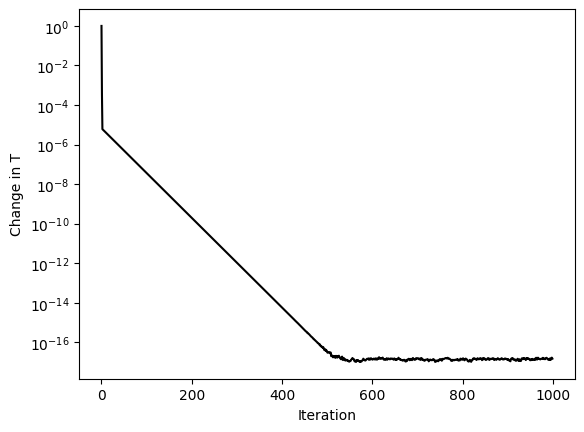

In [50]:
from src.utils.solvers import SoftBregman

blocked_idxs = zip(l_idxs_x, l_idxs_y)

solver = SoftBregman(gamma_0, gamma_c, gamma_r, rows_to_relax, cols_to_relax, blocked_idxs=blocked_idxs)
T = solver.solve(a, b, mu, nu, plot=True)

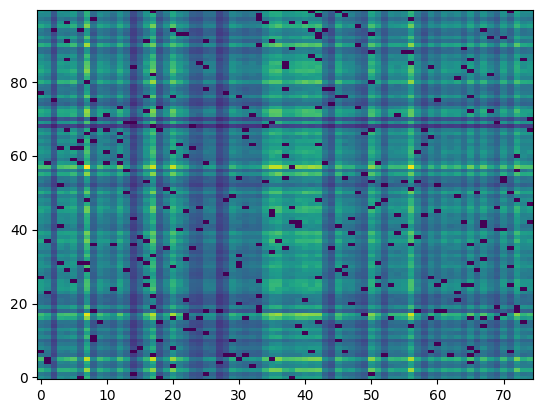

In [51]:
plt.pcolormesh(b, a, T)

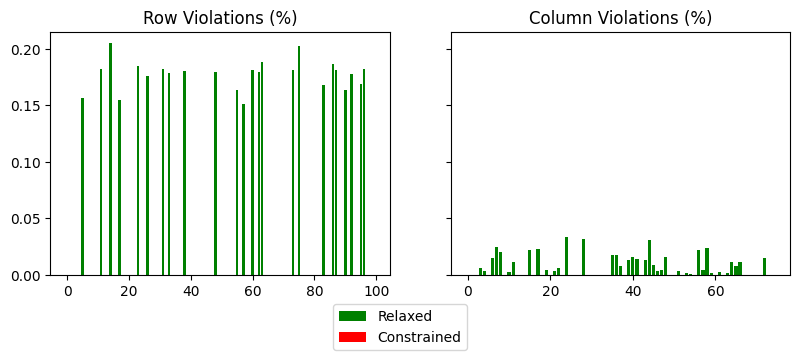

In [52]:
from matplotlib.patches import Patch

fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(9,4), sharey='row')

def binary_to_colour(arr):
    colours = np.array(arr, dtype=str)
    colours[arr == 1] = 'green'
    colours[arr == 0] = 'red'
    return colours

ax_r.bar(x=np.arange(num_a), height=np.abs(mu_0 - np.sum(T, axis=1)) / mu_0, color=binary_to_colour(rows_to_relax.reshape(-1,)))
ax_r.set_title('Row Violations (%)')

ax_c.bar(x=np.arange(num_b), height=np.abs(nu_0 - np.sum(T, axis=0)) / nu_0, color=binary_to_colour(cols_to_relax.reshape(-1,)))
ax_c.set_title('Column Violations (%)')

fig.tight_layout(pad=4)
fig.legend(labels=['Relaxed', 'Constrained'], handles=[Patch(facecolor='green'), Patch(facecolor='red')], loc='outside lower center')

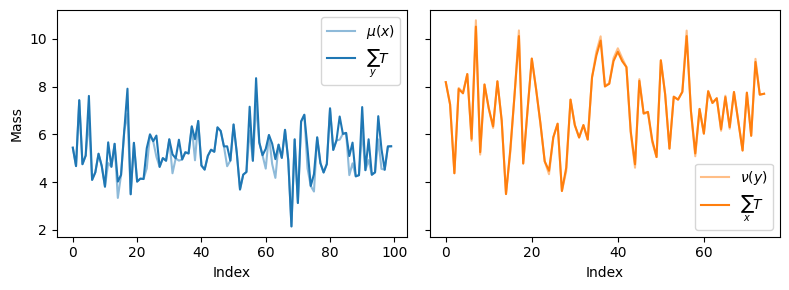

In [53]:
fig, axs = plt.subplots(1,2, sharey='all', figsize=(8,3))

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)

axs[0].plot(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c='tab:blue')
axs[1].plot(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c='tab:orange')

axs[0].set_xlabel('Index')
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Mass')

axs[0].legend()
axs[1].legend()
fig.tight_layout()

# Dykstra Bounded Solver

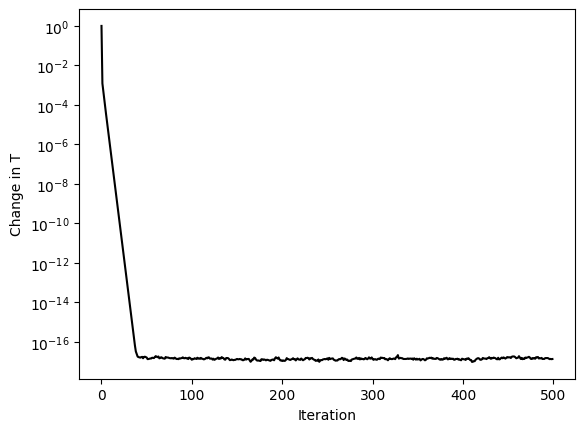

In [54]:
from src.utils.solvers import BoundedDykstra

blocked_idxs = zip(l_idxs_x, l_idxs_y)

m_ub, m_lb = mu.copy(), mu.copy()
m_ub[np.where(rows_to_relax == 1)[0]] *= 1.2
m_lb[np.where(rows_to_relax == 1)[0]] *= 0.8

n_ub, n_lb = nu.copy(), nu.copy()
n_ub[np.where(cols_to_relax == 1)[1]] *= 1.2
n_lb[np.where(cols_to_relax == 1)[1]] *= 0.8

solver = BoundedDykstra(gamma_0, m_ub, m_lb, n_ub, n_lb, blocked_idxs=blocked_idxs)
T = solver.solve(a, b, mu, nu, num_iters=int(5e2), plot=True)

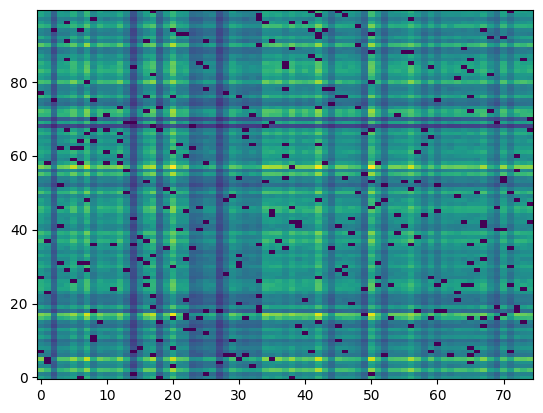

In [55]:
plt.pcolormesh(b, a, T)

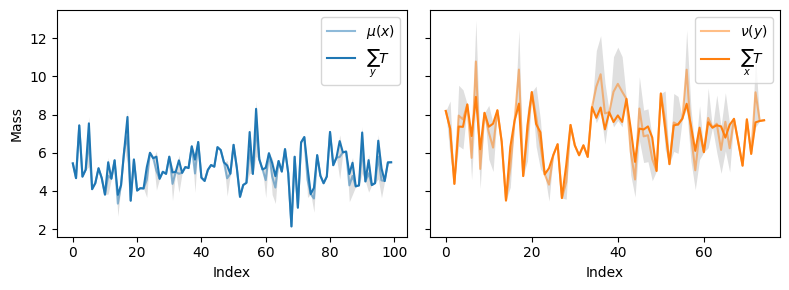

In [56]:
fig, axs = plt.subplots(1,2, sharey='all', figsize=(8,3))

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)

axs[0].fill_between(a, m_ub, m_lb, color='gray', alpha=0.25, lw=0)
axs[1].fill_between(b, n_ub, n_lb, color='gray', alpha=0.25, lw=0)

axs[0].plot(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c='tab:blue')
axs[1].plot(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c='tab:orange')

axs[0].set_xlabel('Index')
axs[1].set_xlabel('Index')
axs[0].set_ylabel('Mass')

axs[0].legend()
axs[1].legend()
fig.tight_layout()